# <center> Практика. Статистические тесты в контексте EDA

## Постановка задачи

### HR-агентство изучает тренды на рынке труда в IT. Компания хочет провести исследование на основе данных о зарплатах в сфере Data Science за 2020–2022 годы и получить некоторые выводы.

### В процессе своего анализа вы должны:

Выяснить, какие факторы влияют на зарплату специалиста Data Scientist.
А также ответить на ключевые вопросы HR-агентства:
Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?
Если вы найдёте в данных интересные закономерности, также отметьте их в своём анализе.

Продемонстрируйте использование разных тестов для проверки статистической значимости сделанных выводов:

тесты для количественного признака:
для одной выборки;
для двух выборок;
для нескольких выборок;
тест для категориальных признаков.

In [1]:
# загружаем необходимые библиотеки
import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
from statsmodels import stats as sms

import matplotlib.pyplot as plt
import seaborn as sns

# делаем визуальную настройку графиков
sns.set_theme("notebook") 
sns.set_palette("Set2") 

In [4]:
# загружаем датасет
import os

os.chdir(r'C:\Users\VEZem\Desktop\new\LearnPandas\data')
data = pd.read_csv('ds_salaries.csv')
data.head()

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


## Описательный анализ данных

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          607 non-null    int64 
 1   work_year           607 non-null    int64 
 2   experience_level    607 non-null    object
 3   employment_type     607 non-null    object
 4   job_title           607 non-null    object
 5   salary              607 non-null    int64 
 6   salary_currency     607 non-null    object
 7   salary_in_usd       607 non-null    int64 
 8   employee_residence  607 non-null    object
 9   remote_ratio        607 non-null    int64 
 10  company_location    607 non-null    object
 11  company_size        607 non-null    object
dtypes: int64(5), object(7)
memory usage: 57.0+ KB


В датасете 607 записей (без пропущенных значений).
Проверим данные на наличие полных дубликатов:

In [6]:
print('Количество дубликатов: {}'.format(data[data.duplicated()].shape[0]))

# Удаляем дубликаты:
data = data.drop_duplicates()
print('Размер таблицы после удаления дубликатов: {}'.format(data.shape))

Количество дубликатов: 0
Размер таблицы после удаления дубликатов: (607, 12)


### Данные не содержат дубликатов. Имеются категориальные и количественные признаки. Значимым признаком для нас является зарплата, пересчитанная в долларах. Ее в дальнейшем и будем анализировать в зависимости от размера компаний, опыта работы, страны регистрации компании и тд.

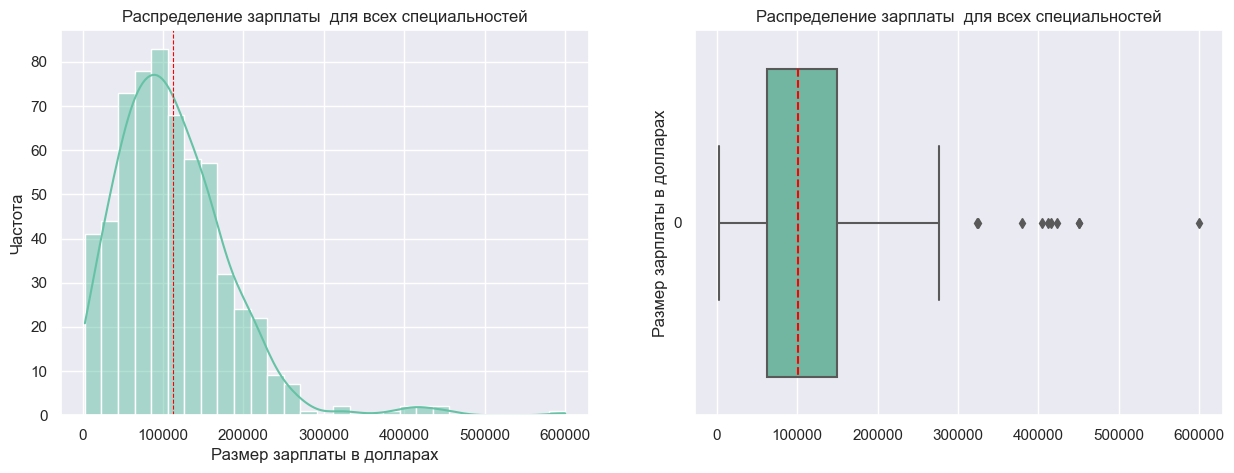

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data['salary_in_usd'], kde=True, ax=axes[0])
axes[0].set(xlabel='Размер зарплаты в долларах', ylabel='Частота')
axes[0].set_title('Распределение зарплаты  для всех специальностей')
axes[0].axvline(data['salary_in_usd'].mean(), color='red', linestyle='--', linewidth=0.8)

sns.boxplot(data['salary_in_usd'], ax=axes[1], orient='h', medianprops={"color": "red", "linestyle": '--'})
axes[1].set(ylabel='Размер зарплаты в долларах')
axes[1].set_title('Распределение зарплаты  для всех специальностей')

plt.show()

In [10]:
data_agg = data['salary_in_usd'].describe().round(2).to_frame()
data_agg.columns = ['Размер зарплаты в долларах']
data_agg

,Размер зарплаты в долларах
count,607.00
mean,112297.87
std,70957.26
min,2859.00
25%,62726.00
50%,101570.00
75%,150000.00
max,600000.00


### Проверим распределение на нормальность

In [12]:
import scipy.stats as stats

# задаём уровень значимости
alpha = 0.05 



# проводим тест Шапиро — Уилка
_, p = stats.shapiro(data['salary_in_usd'])

print('p-value = %.3f' % (p))

# интерпретируем результат
if p <= alpha:
    print('Распределение не нормальное')
else:
    print('Распределение нормальное')


p-value = 0.000
Распределение не нормальное


Распределение зарплат отлично от нормального. Необходимо использовать соответствующие тесты

### Рассмотрим распределение зарплат в зависимости от (experience_level) должности.

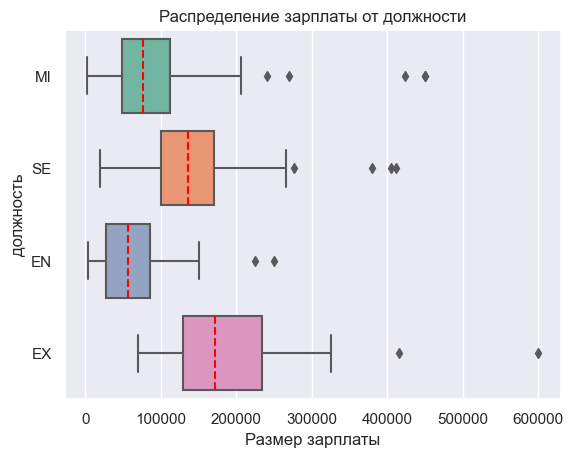

In [23]:

ax = sns.boxplot(data, x='salary_in_usd', y='experience_level', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер зарплаты', ylabel='должность')
plt.title('Распределение зарплаты от должности')
plt.show()

In [28]:
data_agg = data.groupby('experience_level')['salary_in_usd'].describe().round(2)
print('Распределение зарплаты от должности')
data_agg.sort_values(by='mean', ascending=False)


Распределение зарплаты от должности


,count,mean,std,min,25%,50%,75%,max
experience_level,,,,,,,,
EX,26.0,199392.04,117071.26,69741.0,130006.5,171437.5,233750.00,600000.0
SE,280.0,138617.29,57691.98,18907.0,100000.0,135500.0,170000.00,412000.0
MI,213.0,87996.06,63901.06,2859.0,48000.0,76940.0,112000.00,450000.0
EN,88.0,61643.32,44395.54,4000.0,27505.0,56500.0,85425.75,250000.0


### Видим что зарплата специалиста растет в соответствии с уровнем занимемой должности. От начинающего до директора.

### Рассмотрим распределение зарплат в зависимости от (employment_type) типа трудоустройства.


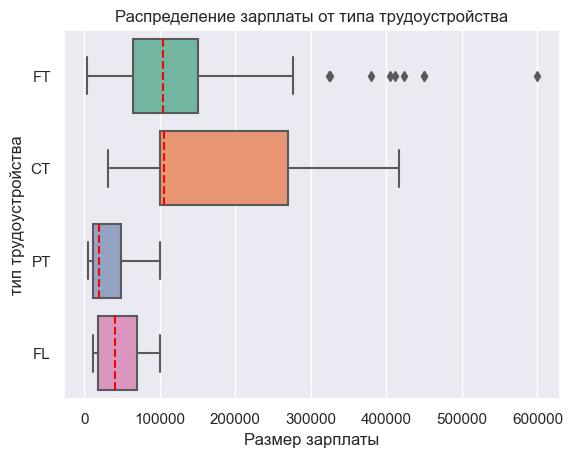

In [29]:
ax = sns.boxplot(data, x='salary_in_usd', y='employment_type', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер зарплаты', ylabel='тип трудоустройства')
plt.title('Распределение зарплаты от типа трудоустройства')
plt.show()

In [30]:
data_agg = data.groupby('employment_type')['salary_in_usd'].describe().round(2)
print('Распределение зарплаты от типа трудоустройства')
data_agg.sort_values(by='mean', ascending=False)

Распределение зарплаты от типа трудоустройства


,count,mean,std,min,25%,50%,75%,max
employment_type,,,,,,,,
CT,5.0,184575.00,156250.89,31875.0,100000.00,105000.0,270000.0,416000.0
FT,588.0,113468.07,69476.47,2859.0,64962.25,104196.5,150000.0,600000.0
FL,4.0,48000.00,40529.82,12000.0,18000.00,40000.0,70000.0,100000.0
PT,10.0,33070.50,31472.91,5409.0,12000.00,18817.5,48370.0,100000.0


### Видим высокие зарплаты для работающих по контракту и на полный день. Работающие неполный раюочий день и фрилансеры имеют в среднем в разы меньшую зарплату.